In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import os
from glob import glob
import pywt

# Load Data

In [2]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [3]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [4]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [16]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [17]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [18]:
OHLC = full_df[:,:,[1,2,3,4]] 
OHLC.shape

(7661, 1500, 4)

In [19]:
volume_features = full_df[:,:,[5,6,7,8,9]]
volume_features.shape

(7661, 1500, 5)

# Train/Validation Split

In [20]:
indexes = [i for i in range(7661)]
train_idx, val_idx, _, _ = train_test_split(indexes, indexes, test_size = 0.1, random_state = 42)

In [21]:
train_price = OHLC[train_idx, :, :] 
val_price = OHLC[val_idx, :, :] 

train_volume = volume_features[train_idx, :, :] 
val_volume = volume_features[val_idx, :, :] 

train_price.shape, val_price.shape

((6894, 1500, 4), (767, 1500, 4))

In [22]:
train_volume.shape, val_volume.shape

((6894, 1500, 5), (767, 1500, 5))

# Create Training Generator

In [179]:
def noise_augmentation(arr): 
    ret = np.zeros(shape=arr.shape, dtype=np.float32)
    for j in range(arr.shape[1]): 
        sample_price = arr[:,j] 
        rand_idx = np.random.randint(1,20)
        transform_type = 'db'+str(rand_idx)
        cA,cD = pywt.dwt(sample_price, transform_type) 
        K = sample_price.shape[0] / cA.shape[0] 
        #lamb = 0.1
        #A = 0.25
        #factor = 0.1 
        #for idx in range(cD.shape[0]): 
        #    cD[idx] = cD[idx] + np.power((1-lamb), idx*K) * A * np.random.normal(0,factor*np.std(sample_price))
        cD = cD + np.random.normal(0,np.random.uniform(0.0001,0.001))
        reconstructed = pywt.idwt(cA,cD,transform_type) 
        assert (reconstructed >= 0).all()  
        ret[:,j] = reconstructed 
    return ret 

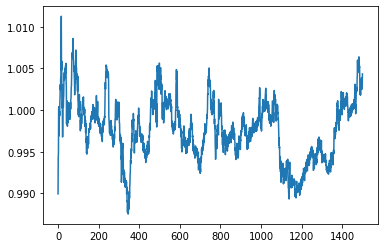

In [180]:
sample = OHLC[10,:,:] 
noised = noise_augmentation(sample)
plt.plot(noised[:,0])

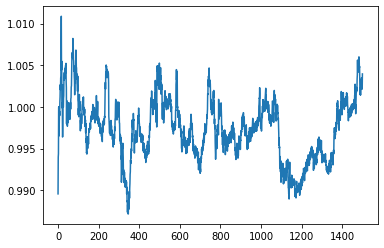

In [184]:
buy_price = noised[1379,0] 
if buy_price > 1.0: 
    diff = buy_price -1.0 
    noised -= diff 
elif buy_price < 1.0:  
    diff = 1.0-buy_price
    noised += diff 
plt.plot(noised[:,0])

In [185]:
noised[:,0]

array([0.9895771, 0.9939929, 0.9943828, ..., 1.0033121, 1.0021433,
       1.0039614], dtype=float32)

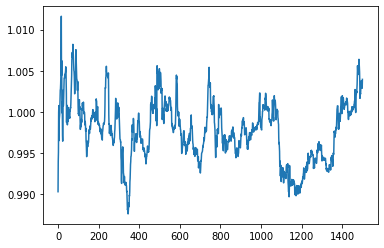

In [182]:
plt.plot(sample[:,0])

In [186]:
sample[:,0]

array([0.99032378, 0.99399298, 0.99512947, ..., 1.00331211, 1.00288999,
       1.00396144])

In [197]:
def interpolation_augmentation(arr): 
    ret = np.zeros(shape=arr.shape, dtype=np.float32)
    for j in range(arr.shape[1]): 
        sample_price = arr[:,j] 
        rand_idx = np.random.randint(1,20)
        transform_type = 'db'+str(rand_idx)
        cA,cD = pywt.dwt(sample_price, transform_type) 
        augmented = np.zeros(shape=cA.shape)
        beta = 0.4  
        for idx in range(cD.shape[0]): 
            neighbor = random.sample([1,2,3,4,5], 1)[0]
            if idx+neighbor < cD.shape[0]:  
                s_tilde = cD[idx+neighbor]
            elif idx-neighbor >= 0: 
                s_tilde = cD[idx-neighbor]
            s = cD[idx] 
            s_prime = (s_tilde - s) * beta + s 
            augmented[idx] = s_prime  
        
        reconstructed = pywt.idwt(cA,augmented,transform_type) 
        assert (reconstructed >= 0).all()  
        ret[:,j] = reconstructed 
    return ret 

In [198]:
sample = OHLC[10,:,:]

In [199]:
interpolated = interpolation_augmentation(sample)

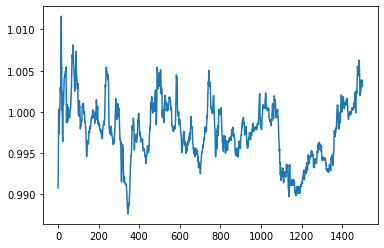

In [200]:
plt.plot(interpolated[:,0])

In [201]:
interpolated[:,0]

array([0.99079204, 0.99291706, 0.9962382 , ..., 1.0032129 , 1.0030688 ,
       1.0038166 ], dtype=float32)

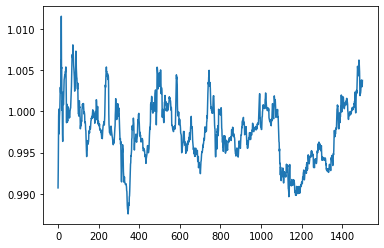

In [203]:
buy_price = interpolated[1379,0] 
if buy_price > 1.0: 
    diff = buy_price-1.0 
    interpolated -= diff 
elif buy_price < 1.0:  
    diff = 1.0-buy_price 
    interpolated += diff  
    
plt.plot(interpolated[:,0])

In [204]:
interpolated[:,0]

array([0.9907143 , 0.99283934, 0.99616045, ..., 1.0031352 , 1.0029911 ,
       1.0037389 ], dtype=float32)

In [93]:
def valGenerator():
    
    for i in range(val_price.shape[0]): 
        volume = val_volume[i,:,:]
        original = val_price[i,:,:] 
        
        N = 30 
        cnt = 0 
        j = 0 
        features_price = 4
        features_volume = 5
        
        while j+N+K < 1500: 
            cur_price = original[j:j+N,:] 
            cur_volume = volume[j:j+N,:] 
            cur_target = original[j+N+K,0] 
            j += 1 
            yield ((cur_price, cur_volume), cur_target)
            
val_dataset = tf.data.Dataset.from_generator(valGenerator, ((tf.float32,tf.float32),tf.float32), ((tf.TensorShape([30,4]), tf.TensorShape([30,5])),tf.TensorShape([1])))

val_dataset = val_dataset.batch(256).prefetch(1)


# Augment Train dataset 

In [12]:
noised_price = np.zeros((train_price.shape[0], train_price.shape[1], train_price.shape[2]), dtype=np.float32) 
for i in tqdm(range(train_price.shape[0])):  
    for j in range(train_price.shape[2]): 
        sample_price = train_price[i,:,j] 
        cA,cD = pywt.dwt(sample_price, 'db2') 
        
        K = sample_price.shape[0] / cA.shape[0] 
        lamb = 0.1
        A = 0.25
        factor = 0.1 

        for idx in range(cD.shape[0]): 
            cD[idx] = cD[idx] + np.power((1-lamb), idx*K) * A * np.random.normal(0,factor*np.std(sample_price))
        reconstructed = pywt.idwt(cA,cD,'db2') 
        assert (reconstructed >= 0).all()  
        noised_price[i,:,j] = reconstructed 
        
noised_price.shape

100%|██████████| 6894/6894 [15:33<00:00,  7.39it/s]


(6894, 1500, 4)

In [13]:
interpolated_price = np.zeros((train_price.shape[0], train_price.shape[1], train_price.shape[2]))
cnt = 0 
beta = 0.25
for i in tqdm(range(train_price.shape[0])): 
    for j in range(train_price.shape[2]): 
        sample_price = train_price[i,:,j] 
        cA,cD = pywt.dwt(sample_price, 'db2') 
        augmented = np.zeros(shape=cA.shape)
        beta = 0.25  
        for idx in range(cD.shape[0]): 
            neighbor = random.sample([1,2,3,4,5], 1)[0]
            if idx+neighbor < cD.shape[0]:  
                s_tilde = cD[idx+neighbor]
            elif idx-neighbor >= 0: 
                s_tilde = cD[idx-neighbor]
            s = cD[idx] 
            s_prime = (s_tilde - s) * beta + s 
            augmented[idx] = s_prime  
        
        reconstructed = pywt.idwt(cA,augmented,'db2') 
        assert (reconstructed >= 0).all()  
        interpolated_price[i,:,j] = reconstructed 

interpolated_price.shape

100%|██████████| 6894/6894 [01:46<00:00, 64.96it/s]


(6894, 1500, 4)

We compare the plots for the original data, the noised version and the interpolated version. 

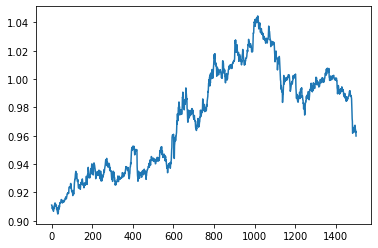

In [14]:
plt.plot(train_price[120,:,0]) 

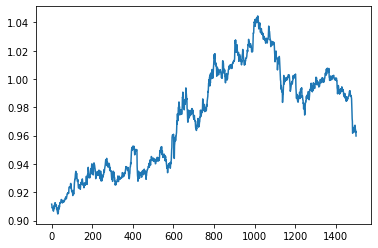

In [15]:
plt.plot(noised_price[120,:,0]) 

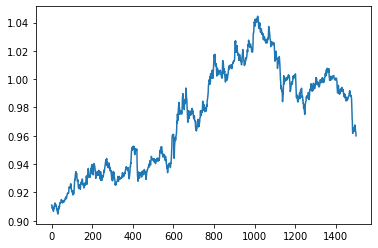

In [16]:
plt.plot(interpolated_price[120,:,0])

In [17]:
train_price[120,:,0]

array([0.91101468, 0.91106486, 0.90996164, ..., 0.96228963, 0.96319234,
       0.95975727])

In [18]:
noised_price[120,:,0]

array([0.9116327 , 0.91098254, 0.90916988, ..., 0.96228963, 0.96319234,
       0.95975727])

In [19]:
interpolated_price[120,:,0]

array([0.91106403, 0.9111215 , 0.90974567, ..., 0.96280382, 0.96243317,
       0.95994787])

We combine the augmented dataset and the train dataset

In [13]:
#train_price = np.concatenate([train_price, noised_price, interpolated_price]) 
#train_volume = np.concatenate([train_volume, train_volume, train_volume]) 

train_price = np.concatenate([train_price, noised_price]) 
train_volume = np.concatenate([train_volume,train_volume]) 
train_price.shape, train_volume.shape


((13788, 1500, 4), (13788, 1500, 5))

# Define and Train model

In [215]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [216]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    

def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding_price = Time2Vector(N)
    time_embedding_volume = Time2Vector(N)
    ## price transformer 
    price_inputs = Input((N, features_price))  
    bn = BatchNormalization()(price_inputs) 
    x = time_embedding_price(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation)
    x = GlobalMaxPooling1D()(x) 
    
    ## volume transformer 
    volume_inputs = Input((N, features_volume)) 
    bn_v = BatchNormalization()(volume_inputs) 
    x_v = time_embedding_volume(bn_v) 
    x_v = Concatenate()([bn_v, x_v]) 
    x_v = Conv1D(node*2, 5, activation = activation)(x_v) 
    x_v = MaxPooling1D(3)(x_v) 
    x_v = Dropout(drop_rate)(x_v)
    x_v = Conv1D(node, 5, activation = activation)(x_v) 
    x_v = MaxPooling1D(3)(x_v) 
    x_v = Dropout(drop_rate)(x_v)
    positions_v = tf.range(start=0, limit=x_v.shape[1], delta=1) 
    positions_v = Embedding(input_dim=x_v.shape[1], output_dim = node)(positions_v) 
    x_v = x_v + positions_v 
    for i in range(num_layers):  
        x_v = transformer_block(x_v, node, drop_rate, activation)  
    x_v = GlobalMaxPooling1D()(x_v) 
    
    merge = Concatenate()([x, x_v]) 
    blend = Dense(64, activation = 'relu')(merge) 
    blend = BatchNormalization()(blend) 
    outputs = Dense(1, activation = 'relu')(blend) 
    model = Model(inputs=[price_inputs, volume_inputs],outputs=outputs) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [217]:
model = build_model()
model.summary() 

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
masking_6 (Masking)             (None, 30, 4)        0           input_7[0][0]                    
__________________________________________________________________________________________________
masking_7 (Masking)             (None, 30, 5)        0           input_8[0][0]                    
____________________________________________________________________________________________

In [218]:
def trainGenerator():
    
    for i in range(train_price.shape[0]): 
        volume = train_volume[i,:,:]
        original = train_price[i,:,:] 
        noised = noise_augmentation(original) 
        interpolated = interpolation_augmentation(original) 
        
        open_noised = noised[1379,0]
        if open_noised > 1.0: 
            diff = open_noised - 1.0 
            noised -= diff 
        elif open_noised < 1.0: 
            diff = 1.0 - open_noised 
            noised += diff 
        
        open_interpolated = interpolated[1379,0] 
        if open_interpolated > 1.0: 
            diff = open_interpolated - 1.0 
            interpolated -= diff 
        elif open_interpolated < 1.0: 
            diff = 1.0 - open_interpolated 
            interpolated += diff 
        
        
        N = 30 
        cnt = 0 
        K = 120 
        features_price = 4
        features_volume = 5
        
        original = original.reshape((-1,original.shape[0],original.shape[1]))
        noised = noised.reshape((-1,noised.shape[0],noised.shape[1])) 
        interpolated = interpolated.reshape((-1,interpolated.shape[0],interpolated.shape[1])) 
        volume = volume.reshape((-1,volume.shape[0],volume.shape[1]))
        
        X_price = np.concatenate([original,noised,interpolated]) 
        X_volume = np.concatenate([volume,volume,volume])
        
        for l in range(X_price.shape[0]): 
            j = 0 
            while j+N+K < 1500: 
                cur_price = X_price[l,j:j+N,:]
                cur_volume = X_volume[l,j:j+N,:] 
                cur_target = X_price[l,j+N+K,0].reshape((-1)) 
                j += 1 
                yield ((cur_price, cur_volume), cur_target)
                
            
train_ds = tf.data.Dataset.from_generator(trainGenerator, ((tf.float32,tf.float32),tf.float32), ((tf.TensorShape([30,4]), tf.TensorShape([30,5])),tf.TensorShape([1])))

train_ds = train_ds.batch(512)


In [219]:
def valGenerator():
    for i in range(val_price.shape[0]): 
        volume = val_volume[i,:,:]
        original = val_price[i,:,:] 
        
        N = 30 
        cnt = 0 
        K = 120 
        features_price = 4
        features_volume = 5
        j = 0 
        while j+N+K < 1500: 
            cur_price = original[j:j+N,:] 
            cur_volume = volume[j:j+N,:] 
            cur_target = original[j+N+K,0].reshape((-1)) 
            j += 1 
            yield ((cur_price, cur_volume), cur_target)
            
val_ds = tf.data.Dataset.from_generator(valGenerator, ((tf.float32,tf.float32),tf.float32), ((tf.TensorShape([30,4]), tf.TensorShape([30,5])),tf.TensorShape([1])))

val_ds = val_ds.batch(512)


In [ ]:
model_path = 'transformer_augmentation_generator_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(train_ds, 
                    epochs = 50, 
                    callbacks = [learning_rate_reduction, checkpoint], 
                    validation_data = val_ds)


Epoch 1/50
54533/54533 [==============================] - 5209s 95ms/step - loss: 3.4786 - mae: 0.0348 - mse: 0.0066 - mape: 3.4786 - val_loss: 4.7590 - val_mae: 0.0479 - val_mse: 0.0028 - val_mape: 4.7590

Epoch 00001: val_loss improved from inf to 4.75904, saving model to transformer_augmentation_generator_epoch_001_val_4.759.h5
Epoch 2/50
 2997/54533 [>.............................] - ETA: 1:20:40 - loss: 2.4181 - mae: 0.0242 - mse: 0.0016 - mape: 2.4181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54533/54533 [==============================] - 5243s 96ms/step - loss: 2.4096 - mae: 0.0241 - mse: 0.0014 - mape: 2.4096 - val_loss: 2.7273 - val_mae: 0.0270 - val_mse: 0.0011 - val_mape: 2.7273

Epoch 00002: val_loss improved from 4.75904 to 2.72727, saving model to transformer_augmentation_generator_epoch_002_val_2.727.h5
Epoch 3/50
54533/54533 [==============================] - 5185s 95ms/step - loss: 2.2616 - mae: 0.0226 - mse: 0.0013 - mape: 2.2616 - val_loss: 1.6559 - val_mae: 0.0164 - val_mse: 8.1565e-04 - val_mape: 1.6559

Epoch 00003: val_loss improved from 2.72727 to 1.65594, saving model to transformer_augmentation_generator_epoch_003_val_1.656.h5
Epoch 4/50
40783/54533 [=====================>........] - ETA: 21:02 - loss: 2.1651 - mae: 0.0217 - mse: 0.0013 - mape: 2.1651

# Make Prediction

In [ ]:
best_model = load_model('', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary()


In [ ]:
X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape


In [ ]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


In [ ]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff

In [ ]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_augmentation.csv',index=False)
